# Analysis of Wisconsin Diagnostic Breast Cancer Data

## Imports

We'll start with a few general imports that we will be using throughout the notebook. Other more specific imports will be included as and when they are needed.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Data preparation 

Lets start by loading the data using pandas. The raw format is a csv file with no headers. We will need to add the headers manually based on the description document provided in the same location as the data in the file 'wdbc.names'. 

In [2]:
columnNames = ['ID', 'Diagnosis', 'Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 
               'Compactness', 'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension', 
               'seRadius', 'seTexture', 'sePerimeter', 'seArea', 'seSmoothness', 'seCompactness', 'seConcavity', 
               'seConcavePoints', 'seSymmetry', 'seFractalDimension', 'worstRadius', 'worstTexture', 
               'worstPerimeter', 'worstArea', 'worstSmoothness', 'worstCompactness', 'worstConcavity', 
               'worstConcavePoints', 'worstSymmetry', 'worstFractalDimension']

dataURL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

df = pd.read_csv(dataURL, header=None, names=columnNames)

Lets have a quick look at the first few rows to get a general feel for the data.

In [3]:
df.head()

,ID,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,ConcavePoints,...,worstRadius,worstTexture,worstPerimeter,worstArea,worstSmoothness,worstCompactness,worstConcavity,worstConcavePoints,worstSymmetry,worstFractalDimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We can ignore the ID column as this is not relevant to our purposes. Hence, the first column is 'Diagnosis', which classifies the data into Malignant ('M') or Benign ('B') categories. The remaining columns are all continuous (i.e. float), real valued features.

Lets now check if there are any missing values.

In [4]:
df.isnull().sum()

ID                       0
Diagnosis                0
Radius                   0
Texture                  0
Perimeter                0
Area                     0
Smoothness               0
Compactness              0
Concavity                0
ConcavePoints            0
Symmetry                 0
FractalDimension         0
seRadius                 0
seTexture                0
sePerimeter              0
seArea                   0
seSmoothness             0
seCompactness            0
seConcavity              0
seConcavePoints          0
seSymmetry               0
seFractalDimension       0
worstRadius              0
worstTexture             0
worstPerimeter           0
worstArea                0
worstSmoothness          0
worstCompactness         0
worstConcavity           0
worstConcavePoints       0
worstSymmetry            0
worstFractalDimension    0
dtype: int64

Fortunately, there is no missing data. Let's continue with the data preparation - the next step is to split the data into training and test sets. 

First, set the number of training and test samples

In [5]:
n_samples, n_features = df.shape
train_test_ratio = 0.7
n_training_samples = int(n_samples * 0.7)
n_test_samples = n_samples - n_training_samples

Shuffle the data and split into training and test sets.

In [6]:
dfShuffled = df.sample(frac=1)
dfTrain = dfShuffled.iloc[0:n_training_samples,:]
dfTest = dfShuffled.iloc[n_training_samples:n_samples,:]
dfTrainX = dfShuffled.iloc[0:n_training_samples,2:n_features]
dfTestX = dfShuffled.iloc[n_training_samples:n_samples,2:n_features]
dfTrainY = dfShuffled['Diagnosis'].iloc[0:n_training_samples]
dfTestY = dfShuffled['Diagnosis'].iloc[n_training_samples:n_samples]

Convert data to arrays

In [7]:
X_train = dfTrainX.values.astype(float)
X_test = dfTestX.values.astype(float)
y_train = (dfTrainY.values == 'M').astype(int)
y_test = (dfTestY.values == 'M').astype(int)

Confirm data is of the correct shape - 398 training samples, 171 test samples, 30 features.

In [8]:
X_train.shape , X_test.shape

((398, 30), (171, 30))

Do some checks to confirm that data is split correctly.

Check that the total number of malignant labeled samples across training and test sets is equal to the original data.

In [9]:
y_train.sum() + y_test.sum() == (df['Diagnosis'] == 'M').sum()

True

Pick a feature and make sure the sum of all samples across training and test sets equals the sum in the original data.

In [10]:
abs(X_train[:,0].sum() + X_test[:,0].sum() - df['Radius'].sum()) < 0.0000000001

True

## Visualisations 

Before we begin to analyse the data it is almost always useful to visualise it. 2D scatter plots allow us to visualise how the categories are spread out amongst two given features. Since there are too many features to plot every possible combination, we will just pick a few pairings at random.

First, some helper functions for draw scatter plots

In [11]:
def plot_data_np(X1, X2, Y, x1Label, x2Label, ax):
    
    title = x1Label + ' vs ' + x2Label
    
    x1Min = X1.min()
    x1Max = X1.max()
    x2Min = X2.min()
    x2Max = X2.max()
    
    ax.plot(X1[Y==0], X2[Y==0], "bs")    
    ax.plot(X1[Y==1], X2[Y==1], "r^")
    ax.axis([x1Min, x1Max, x2Min, x2Max])
    ax.set_xlabel(x1Label)
    ax.set_ylabel(x2Label)
    ax.set_title(title)
    
def plot_data(df, x1Label, x2Label, ax):
    
    plot_data_np(df[x1Label].values, df[x2Label].values, (df['Diagnosis'].values == 'M')*1, x1Label, x2Label, ax)

Now lets plot some examples. We are going to try:
1. Radius vs Perimeter
2. Area vs Symmetry
3. Compactness vs Concavity
4. Radius vs ConcavePoint

<Figure size 432x288 with 0 Axes>

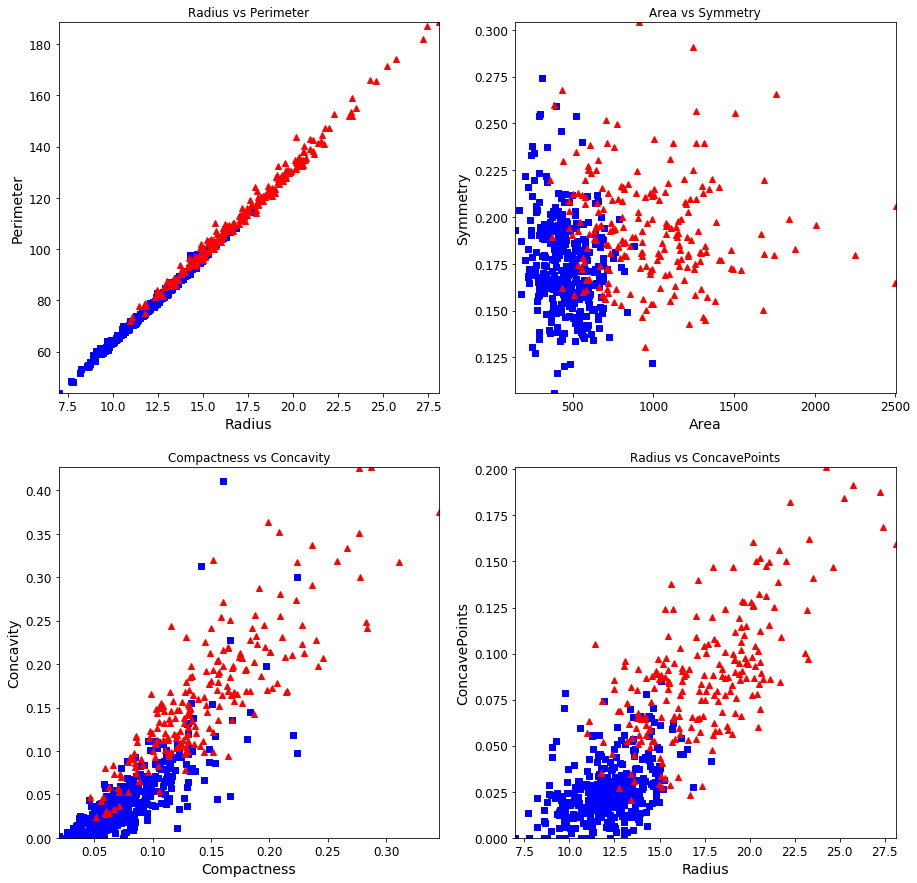

In [12]:
plt.figure(1)
fig, axarr = plt.subplots(2, 2)
plot_data(df, 'Radius', 'Perimeter', axarr[0, 0])
plot_data(df, 'Area', 'Symmetry', axarr[0, 1])
plot_data(df, 'Compactness', 'Concavity', axarr[1, 0])
plot_data(df, 'Radius', 'ConcavePoints', axarr[1, 1])
fig.set_size_inches(15, 15)
plt.show()

We can see that the classes are approximately linearly separable in some cases, although there is considerable overlap. Radius vs perimeter is quite striking because of the clearly linear relationship between the two variables, however, this is not relevant for classification. It would be useful for linear regression but that is not our goal here. 

## Part 1: Mean, Median and Variance of Perimeter 

The mean, median and standard deviation can easily be obtained use the Dataframe.description() method provided by the Pandas library.
Mean is given as 'mean', standard deviation as 'std', and the median by '50%' (i.e. the 50th percentile).

In [13]:
dfTrainX.append(dfTestX)['Perimeter'].describe()

count    569.000000
mean      91.969033
std       24.298981
min       43.790000
25%       75.170000
50%       86.240000
75%      104.100000
max      188.500000
Name: Perimeter, dtype: float64

## Part 2: Distribution of Radius

### Histogram 

We want to examine the distribution of the feature 'Radius', and, in particular, whether it appears to be normally distributed. Again, visualisation is a very useful starting point. In this case, a histogram ought to be quite informative...

First, pull in the data from the dataframe and calculate, mean, standard deviation, min and max.

In [14]:
radii = df['Radius'].values
mean = df['Radius'].mean()
std = df['Radius'].std()
minRadius, maxRadius = np.min(radii) , np.max(radii)

Now plot the data as a histogram. In addition, we are going to generate some random samples from a normal distribution with the same mean and standard deviation and plot it on the same graph for comparison.

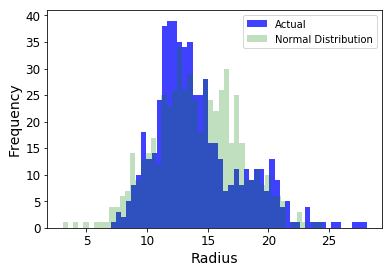

In [15]:
import random

actual_samples = df['Radius'].values
norm_samples = [random.gauss(mean, std) for _ in range(n_samples)]

plt.figure(2)
plt.hist(actual_samples, 50, alpha=0.75, label='Actual', density=False, color='b')
plt.hist(norm_samples, 50, alpha=0.25, label='Normal Distribution', density=False, color='g')
plt.legend(loc='upper right')
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.show()

The actual data is in blue, and the sampled normal distribution is in green. As we can see, there is a visible discrepancy between the two. The actual distibution looks skewed to the left - a normal distribution should be symmetric.

### Skewness 

Following on from the observations above, we can measure how much the data is skewed using the skew metric provided by Pandas. Zero skew means a symmetric distribution.

In [16]:
df['Radius'].skew()

0.9423795716730992

The skew is quite significant, which suggests that Radius not normally distributed.

### Formal test of fit 

SciPy has a built in function to test normality. It is based on D’Agostino and Pearson’s test for normality.

In [17]:
stats.normaltest(radii)

NormaltestResult(statistic=73.17938185797058, pvalue=1.286172249506454e-16)

We would expect the p-value to be greater than 0.05 to be able to reasonably say that Radius us normally distributed. However, it is nowhere near that value, so we need to reject the (null) hypothesis that this feature is normally distributed.

### Alternative distributions 

If the data is not normally distributedm then what alternatives are there? There are many skewed distributions that we could choose from, but as an example we are going to look at just one - the Gamma distrubtion.

The prbability density function (pdf) of the gamma distribution is characterised be the parameters alpha and beta. Now, wWe know that the mean and variance of a variable X which has a gamma distribution are:

$$E(X) = \alpha\beta$$
$$Var(X) = \alpha\beta^2$$

Hence, we can easily calculate alpha and beta as follows:

In [18]:
beta = std ** 2 / mean
alpha = mean / beta

And now we can generate some samples from a gamma distribution.

In [19]:
gamma_samples = [random.gammavariate(alpha, beta) for _ in range(n_samples)]

Let's plot these against the data to see how they compare.

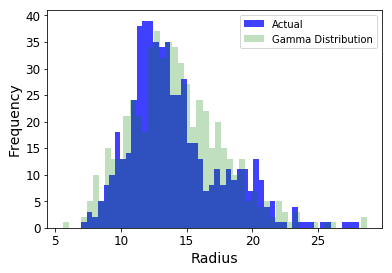

In [20]:
plt.figure(3)
plt.hist(actual_samples, 50, alpha=0.75, label='Actual', density=False, color='b')
plt.hist(gamma_samples, 50, alpha=0.25, label='Gamma Distribution', density=False, color='g')
plt.legend(loc='upper right')
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.show()

This looks slightly more promising, although there are still some large differences in the 15-20 range. In a more detailed analysis we would look at some more distributions and formally analyse them for goodness of fit (e.g. using Chi squared test of fit, or Kolmogorov-Smirnov test, etc), however we will stop at this point and go on to look at some classification algorithms.

## Part 3: Train some classifiers

In the following section we will be making use of some pre-defined classifiers from the Scikit-Learn library.

### Dumb classifier 

First, let's create a dumb clasifier as a baseline. The dumb classifier simply chooses classes at random with no regards for the features. 

In [21]:
y_pred_dumb = np.random.randint(2, size=y_test.shape[0])

In [22]:
from sklearn import metrics

We will use the F1-score as a measure of model performance. It is a useful, concise metric for indicating how 'good' a classifier is, combining both precision and recall. A perfect F1 score is 1. As we can see, the dumb classifier is far from this value:

In [23]:
metrics.f1_score(y_test, y_pred_dumb)

0.38961038961038963

### Logistic Regression 

Now let's try a simple logistic regression using just two features.

#### Using two features 

In [24]:
from sklearn.linear_model import LogisticRegression

Select two features:

In [25]:
featureIndices = (3,8) # Area and symmetry

Train a logistic classifier on the training data:

In [26]:
logisticClassifier = LogisticRegression(C=1, random_state=42)
logisticClassifier.fit(X_train[:,featureIndices], y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Get the predictions of this classifer on the test data:

In [27]:
y_pred_logistic = logisticClassifier.predict(X_test[:,featureIndices])

Evaluate using the F1-score:

In [28]:
metrics.f1_score(y_test, y_pred_logistic)

0.8411214953271029

A lot better than the dumb classifier, but there is room for improvement...

We can plot the decision boundary of this classifier against the data. Remember that the desicion boundary in a ligistic classifier is when: 

$$w_0  + w_1x_1 + w_2x_2 = 0$$

In [29]:
def plot_boundary_np(w0, w1, w2, X1, X2, Y, ax):
       
    x1Min = X1.min()
    x1Max = X1.max()
    x2Min = X2.min()
    x2Max = X2.max()
    x1vals = np.linspace(x1Min, x1Max, 100)                  
    x2vals = -(w1 * x1vals + w0) / w2
    ax.axis([x1Min, x1Max, x2Min, x2Max])
    ax.plot(x1vals, x2vals, "k-")

<Figure size 432x288 with 0 Axes>

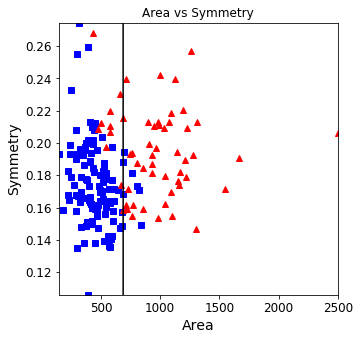

In [30]:
w0 = logisticClassifier.intercept_
w = logisticClassifier.coef_[0]
X1 = X_test[:,featureIndices[0]]
X2 = X_test[:,featureIndices[1]]
Y = y_test
x1Label = dfTrainX.columns.values[featureIndices[0]]
x2Label = dfTrainX.columns.values[featureIndices[1]]

plt.figure(3)
fig, axarr = plt.subplots(1, 1)
plot_data_np(X1, X2, Y, x1Label, x2Label, axarr)
plot_boundary_np(w0, w[0], w[0], X1, X2, Y, axarr)
fig.set_size_inches(5, 5)
plt.show()

This seems like a reasonable way to split the data, but one would have though a more sloped boundary would have been more effecive. Moving on...

#### Using all features 

Now we are going to train the logistic classifier using all of the features.

In [31]:
logisticClassifier = LogisticRegression(C=1, random_state=42)
logisticClassifier.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
y_pred_logistic = logisticClassifier.predict(X_test)

In [33]:
metrics.f1_score(y_test, y_pred_logistic)

0.9549549549549549

Another large improvement, we have crept into the nineties now. Next stop - Support Vector Machines (SVM).

### Linear SVM using two features

Lets try a linear SWM classifier using the same two features that we tried above,

In [34]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Data must be equally scaled in order for SVM's to be trained successfully, so we we make use of the SciKit-Learn Pipelines feature to add this in before training the model.

In [35]:
linearSVMPipeline = Pipeline([("scaler", StandardScaler()),('linearSVC',SVC(kernel="linear", C=1.0))])
linearSVMPipeline.fit(X_train[:,featureIndices], y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearSVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Now get the model's predictions on the test data and calclate the F1-score:

In [36]:
y_pred_linear_SVM = linearSVMPipeline.predict(X_test[:,featureIndices])

In [37]:
metrics.f1_score(y_test, y_pred_linear_SVM)

0.8571428571428571

This is better than the two-feature logistic classifer. It might be useful to plot the decision boundary to see why...

In [38]:
def plot_svc_decision_boundary_two_features(scaler, classifier, X_test, Y_test, x1Label, x2Label, ax):
    
    X_test_scaled = scaler.fit_transform(X_test)
    X1 = X_test_scaled[:,0]
    X2 = X_test_scaled[:,1]
    x1min = X1.min()
    x1max = X1.max()
    x2min = X2.min()
    x2max = X2.max()
    Y = Y_test
    
    # Plot the data points first
    ax.plot(X1[Y==0], X2[Y==0], "bs")    
    ax.plot(X1[Y==1], X2[Y==1], "r^")
    
    # Now plot decision boundary
    w = classifier.coef_[0]
    w0 = classifier.intercept_[0]

    x0 = np.linspace(x1min, x1max, 200)
    x1 = -w[0]/w[1] * x0 - w0/w[1]

    margin = 1/w[1]
    gutter_up = x1 + margin
    gutter_down = x1 - margin

    ax.plot(x0, x1, "k-", linewidth=2)
    ax.plot(x0, gutter_up, "k--", linewidth=2)
    ax.plot(x0, gutter_down, "k--", linewidth=2)
    
    ax.axis([x1min, x1max, x2min, x2max])
    ax.set_xlabel(x1Label)
    ax.set_ylabel(x2Label)
    ax.set_title(x1Label + ' vs ' + x2Label)

<Figure size 432x288 with 0 Axes>

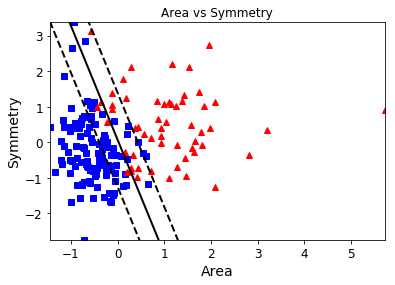

In [39]:
x1Label = dfTrainX.columns.values[featureIndices[0]]
x2Label = dfTrainX.columns.values[featureIndices[1]]
plt.figure(4)
fig, ax = plt.subplots(1, 1)
plot_svc_decision_boundary_two_features(linearSVMPipeline.named_steps['scaler'], 
                                        linearSVMPipeline.named_steps['linearSVC'], 
                                        X_test[:,featureIndices], y_test, x1Label, x2Label, ax)

As suspected, a sloped boundary is indeed more effective, and the SVM has managed to discover this. The dashed lines represent the optimal margins found by the classifier.

### Linear SVM using all features

Now let's repeat the above with all features.

In [40]:
linearSVMPipeline = Pipeline([("scaler", StandardScaler()),('linearSVC',SVC(kernel="linear", C=1.0))])
linearSVMPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearSVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [41]:
y_pred_linear_SVM = linearSVMPipeline.predict(X_test)

In [42]:
metrics.f1_score(y_test, y_pred_linear_SVM)

0.9724770642201834

This is the best result so far - we are almost at 99%

### Kernel SVM using all features

Finally, let's try using a polynomial kernel with degree 1 to see if that does even better.

In [43]:
from sklearn.preprocessing import PolynomialFeatures

In [44]:
kernelSVMPipeline = Pipeline([("scaler", StandardScaler())
                                ,('KernelSVC',SVC(kernel="poly", C=1.0, degree=1))])
kernelSVMPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('KernelSVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [45]:
y_pred_kernel_SVM = kernelSVMPipeline.predict(X_test)

In [46]:
metrics.f1_score(y_test, y_pred_kernel_SVM)

0.9724770642201834

Another very good result. In fact, it is the same as the linear SVM because a degree 1 polynomial is a straight line. Perhaps a degree 2 polynomial will be even better?

In [47]:
kernelSVMPipeline = Pipeline([("scaler", StandardScaler())
                                ,('KernelSVC',SVC(kernel="poly", C=1.0, degree=2))])
kernelSVMPipeline.fit(X_train, y_train)
y_pred_kernel_SVM = kernelSVMPipeline.predict(X_test)
metrics.f1_score(y_test, y_pred_kernel_SVM)

0.6526315789473683

On the contrary, we now see a drastic drop in performance. This is most like due to overfitting since we have given the classfier more degrees of freedom in choosing the shape of the decision boundary.

## Some final thoughts 

A few of the other things we could have tried, time permitting:
1. Principal components analysis (PCA) to reduce dimensionality
2. Hyper parameter exploration
3. Using valdation sets and early stopping to prevent overfitting
4. Neural networks